In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

from einops import rearrange
from einops.layers.torch import Rearrange

import torch
import Simple_ViT.simple_vit as svit
import Simple_ViT.simple_vit_lrp as svitl

import importlib
# When you need to reload the module after an update
importlib.reload(svitl)



import getpass
myname = getpass.getuser()

import pandas as pd

## GPU Handling

In [9]:
def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
gpu_id=0

if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

print('using device: ', device)

device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB
using device:  cuda


## Load the Data

In [ ]:
myname = 'wchapman'
dirout = f'/glade/derecho/scratch/{myname}/TOMSensoDS/'
# Check if the directory exists
if not os.path.exists(dirout):
    # Create the directory
    os.makedirs(dirout)
    print(f"Directory {dirout} created.")
else:
    print(f"Directory {dirout} already exists.")

DSmean_sst_anom = xr.open_dataset(os.path.join(dirout, 'SST_CESM2_PI.nc'))
print('...done loading SST...')

DSmean_trefht_anom_roll = xr.open_dataset(os.path.join(dirout, 'TREFHT_CESM2_PI.nc'))
print('...done loading TREFHT...')


DSmean_sst_anom['time'] = DSmean_trefht_anom_roll['time']

## Let's Lag this Bad Baby

In [ ]:
lead_time = 30
DSmean_sst_anom_lag = DSmean_sst_anom.isel(time=slice(0,-lead_time))
DSmean_trefht_anom_roll_lag = DSmean_trefht_anom_roll.isel(time=slice(lead_time,len(DSmean_trefht_anom_roll['time'])))

##################################################
##### 1700 - 2000
##################################################

date_range = pd.date_range(start='1700-01-01', end='2000-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
end_date_300 = len(filtered_date_range)

print('...gather training...')
y_train = DSmean_trefht_anom_roll_lag.isel(time=slice(0,end_date_300-1))
y_train_anom = y_train.groupby('time.dayofyear') - y_train.groupby('time.dayofyear').mean()
x_train = DSmean_sst_anom_lag.isel(time=slice(0,end_date_300-1))
x_train_anom = x_train.groupby('time.dayofyear') - x_train.groupby('time.dayofyear').mean()

##################################################
##### 2000 - 2100
##################################################
date_range = pd.date_range(start='1700-01-01', end='2101-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
indy_val_s = int(np.where(filtered_date_range == '2000-01-01')[0])
indy_val_e = int(np.where(filtered_date_range == '2100-01-01')[0])

print('...gather validation...')
y_val = DSmean_trefht_anom_roll_lag.isel(time=slice(indy_val_s,indy_val_e))
y_val_anom = y_val.groupby('time.dayofyear') - y_val.groupby('time.dayofyear').mean()
x_val = DSmean_sst_anom_lag.isel(time=slice(indy_val_s,indy_val_e))
x_val_anom = x_val.groupby('time.dayofyear') - x_val.groupby('time.dayofyear').mean()

##################################################
##### 2000 - 2100
##################################################

date_range = pd.date_range(start='1700-01-01', end='2201-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
indy_test_s = int(np.where(filtered_date_range == '2100-01-01')[0])
indy_test_e = int(np.where(filtered_date_range == '2200-01-01')[0])

print('...gather testing...')
y_test = DSmean_trefht_anom_roll_lag.isel(time=slice(indy_test_s,indy_test_e))
y_test_anom = y_test.groupby('time.dayofyear') - y_test.groupby('time.dayofyear').mean()
x_test = DSmean_sst_anom_lag.isel(time=slice(indy_test_s,indy_test_e))
x_test_anom = x_test.groupby('time.dayofyear') - x_test.groupby('time.dayofyear').mean()

In [25]:
y_test_anom

<xarray.Dataset>
Dimensions:    (lat: 42, lon: 41, time: 36471)
Coordinates:
  * lat        (lat) float64 25.92 26.86 27.8 28.74 ... 61.73 62.67 63.61 64.55
  * lon        (lon) float64 200.0 201.2 202.5 203.8 ... 246.2 247.5 248.8 250.0
  * time       (time) datetime64[ns] 2100-01-31 2100-02-01 ... 2200-01-01
    dayofyear  (time) int64 31 32 33 34 35 36 37 ... 360 361 362 363 364 365 1
Data variables:
    TREHT      (time, lat, lon) float32 -0.02139 -0.01309 ... -3.36 -3.269

## Data Loader

In [65]:
class SpatialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.nan_to_num(torch.tensor(X, dtype=torch.float32))
        self.y = torch.tensor(y[:, 30, 10], dtype=torch.float32) #point in ~central alaska
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx].unsqueeze(0)

## Model

In [66]:
batch_size = 16
input_shape = (1, 1, 192, 288) # Example input shape (C, H, W)

#(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,num_heads=12, mlp_ratio=4., qkv_bias=False, mlp_head=False, drop_rate=0., attn_drop_rate=0.):

model = svitl.VisionTransformer(
        image_lr = 192,
        image_ud = 288,
        patch_size = 16,
        num_classes = 1,
        in_chans = 1,
        embed_dim = 3,
        depth = 2,
        num_heads = 3,
        mlp_ratio = 2.,
    ).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_dataset = SpatialDataset(np.array(x_train_anom['SST']), np.array(y_train_anom['TREHT']))
val_dataset = SpatialDataset(np.array(x_val_anom['SST']), np.array(y_val_anom['TREHT']))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [58]:
enso = x_train_anom['SST'].sel(lat=slice(-5,5),lon=slice(190,240)).mean(('lat','lon'))
nino = enso.where(enso >= 2, drop=True)

In [60]:
ynino = y_train_anom['TREHT'][:, 41, 8].sel(time=nino.time)

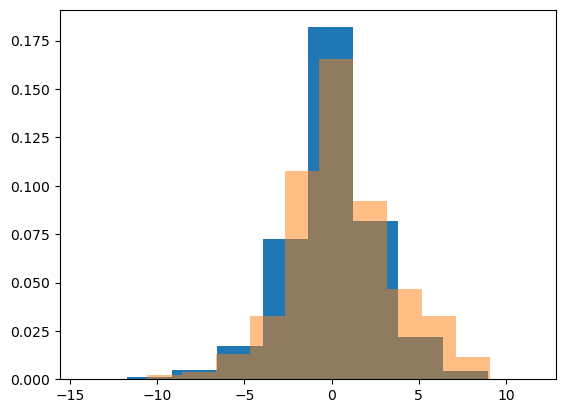

In [61]:
plt.hist(y_train_anom['TREHT'][:, 41, 8],density=True)
plt.hist(ynino,density=True,alpha=0.5)
plt.show()

In [62]:
corrs = np.zeros(shape=(42,41))
for ilat in np.arange(0,len(y_train_anom['TREHT'].lat)):
    for ilon in np.arange(0,len(y_train_anom['TREHT'].lon)):
        corrs[ilat,ilon] = np.corrcoef(enso,y_train_anom['TREHT'][:, ilat, ilon])[0,1]

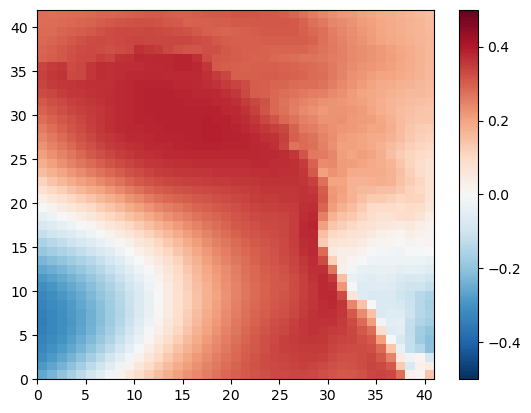

In [64]:
plt.pcolormesh(corrs,cmap='RdBu_r',vmin=-.5,vmax=.5)
plt.colorbar()

## Train

In [89]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 30000:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    mse_val_batch=[]
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.to(device))
            mse_val_batch.append((torch.mean((outputs-labels)**2)))
    # Calculate and print validation accuracy
    mse_tot=torch.mean(torch.tensor(mse_val_batch))
    
    print(f"MSE: {mse_tot:.5f}")
    print( f"r2: {1-(mse_tot/np.var(y_val_anom['TREHT']).values)}")
    
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    elif mse_tot<best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(mse_tot)

Starting Epoch 0
Epoch 0, Loss: 0.4984
MSE: 0.63034
r2: 0.660491943359375
...saved first epoch...
Starting Epoch 1
Epoch 1, Loss: 0.4823
MSE: 0.61463
r2: 0.6689536571502686
...saving!...
Starting Epoch 2
Epoch 2, Loss: 0.4802
MSE: 0.61263
r2: 0.6700311303138733
...saving!...
Starting Epoch 3
Epoch 3, Loss: 0.4757
MSE: 0.61381
r2: 0.6693969964981079
No improvement in validation accuracy.
Starting Epoch 4
Epoch 4, Loss: 0.4712
MSE: 0.61029
r2: 0.671290934085846
...saving!...
Starting Epoch 5
Epoch 5, Loss: 0.4689
MSE: 0.60995
r2: 0.671474814414978
...saving!...
Starting Epoch 6
Epoch 6, Loss: 0.4660
MSE: 0.60722
r2: 0.672946572303772
...saving!...
Starting Epoch 7


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()


In [90]:
outputs = model(inputs.to(device))

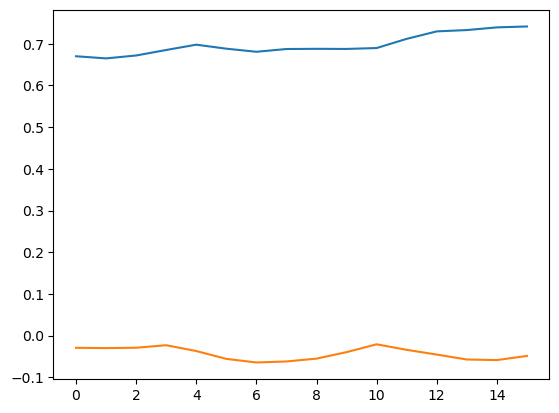

In [91]:
plt.plot(labels.cpu().detach().numpy())
plt.plot(outputs.cpu().detach().numpy())
plt.show()